<a href="https://colab.research.google.com/github/sheldonkemper/bank_of_england/blob/main/notebooks/processed/kk_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
===================================================
Author: Kasia Kirby
Role: Reporting Lead, Bank of England Employer Project (Quant Collective)
LinkedIn: https://www.linkedin.com/in/kasia-kirby
Date: 2025-02-13
Version: 1.0

Description:
    This notebook conducts descriptive analysis on the preprocessed earnings calls transcript data
    to understand its characteristics (e.g., text length, word frequency)
    and generate visualisations (word clouds, histograms) to highlight trends or anomalies.

===================================================
"""

'\n===================================================\nAuthor: Kasia Kirby\nRole: Reporting Lead, Bank of England Employer Project (Quant Collective)\nLinkedIn: https://www.linkedin.com/in/kasia-kirby\nDate: 2025-02-13\nVersion: 1.0\n\nDescription:\n    This notebook conducts descriptive analysis on the preprocessed earnings calls transcript data\n    to understand its characteristics (e.g., text length, word frequency)\n    and generate visualisations (word clouds, histograms) to highlight trends or anomalies.\n\n===================================================\n'

# 1. Import libraries and files

In [ ]:
import os
import sys
from google.colab import drive

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

In [ ]:
# Mount Google Drive to the root location
drive.mount('/content/drive', force_remount=True)
BOE_path = '/content/drive/MyDrive/BOE/bank_of_england/data/preprocessed_data'
print(os.listdir(BOE_path))

Mounted at /content/drive
['unfiltered_preprocessed_JP_qa_sec.csv', 'jpmorgan_preprocessed_transcript.csv', 'preprocessed_santander.csv', 'jpmorgan_management_discussion_preprocessed .csv', 'jpmorgan_qa_section_preprocessed.csv', 'santander_management_discussion_preprocessed.csv', 'ubs_management_discussion_preprocessed.csv', 'ubs_qna_df_preprocessed.csv']


Note: I will start with JPM data for each quarter between 2023-2024.

I have listened to the Q42024 call. My impressions from the call (I do not have investment finance experience)
* Overall positive sentiment.
* 'We remain optimistic' theme across the call.
* Good investments have returned good returns overall.
* CEO leaves in 5 years (mentioned health problems).
* JPM is driving efficiencies in developer departments as part of long term, holistic practice.
* Key vulnerability same as for eveyrone else: unemployment rates that drive credit.

In [ ]:
# Load JPM preprocessed transcripts

files = os.listdir(BOE_path)

jp_morgan_files = [
    'jpmorgan_preprocessed_transcript.csv',
    'jpmorgan_management_discussion_preprocessed .csv',
    'jpmorgan_qa_section_preprocessed.csv',
    'unfiltered_preprocessed_JP_qa_sec.csv'
]

for file in jp_morgan_files:
    file_path = os.path.join(BOE_path, file)

    try:
        df = pd.read_csv(file_path, nrows=5)
        print(f"\n📌 **File: {file}**")
        print(df.columns.tolist())
    except Exception as e:
        print(f"\n⚠️ Could not read {file}: {e}")


📌 **File: jpmorgan_preprocessed_transcript.csv**
['filename', 'chunks', 'quarter', 'call_date']

📌 **File: jpmorgan_management_discussion_preprocessed .csv**
['filename', 'chunk_index', 'chunk_text', 'financial_quarter', 'call_date', 'tokenized_data', 'cleaned_data']

📌 **File: jpmorgan_qa_section_preprocessed.csv**
['speaker', 'marker', 'job_title', 'utterance', 'filename', 'financial_quarter', 'call_date', 'tokenised_data', 'cleaned_data']

📌 **File: unfiltered_preprocessed_JP_qa_sec.csv**
['speaker', 'marker', 'job_title', 'utterance', 'filename', 'financial_quarter', 'call_date']


Steps below are to help us
- **assess data quality** (are the chunks the right size and quality, has preprocessing removed too much info, are tokens well segmented, any unexpected anomalies)
- **understand text characteristics** (text length distribution across sections, most frequent words, speaker level patterns)
- **identify anomalies before further analysis** (stopword/token impact, any speakers overrepresented or missing, does chunking disrupt key themes)

# 2. Analyse text length & structure (preprocessed chunks)

Chunk Size Distribution – How long are the chunks? Are they too short or too long?

Word Count per Quarter – Does discussion length vary across quarters?

Comparison: Management Discussion vs Q&A – Are Q&A sections shorter or longer than management discussions?

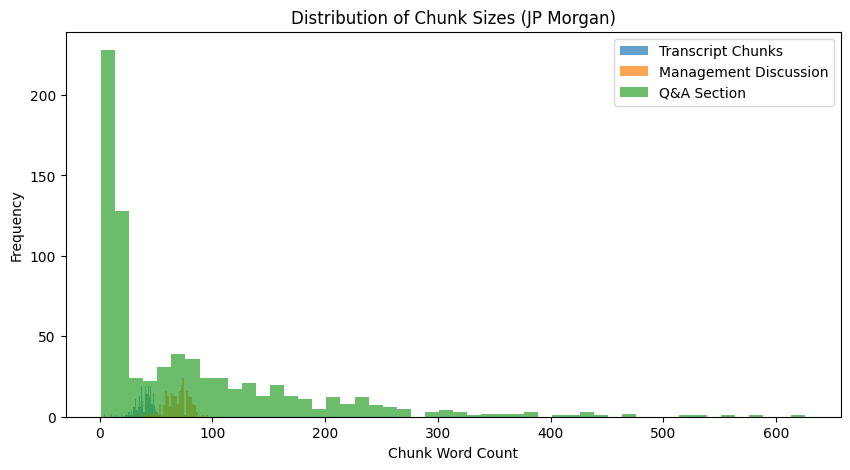

In [ ]:
# Calculate word count per chunk in each dataset

BOE_path = '/content/drive/MyDrive/BOE/bank_of_england/data/preprocessed_data'
transcript_df = pd.read_csv(f"{BOE_path}/jpmorgan_preprocessed_transcript.csv")
management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_discussion_preprocessed .csv") # loading file with space between final period
qa_df = pd.read_csv(f"{BOE_path}/jpmorgan_qa_section_preprocessed.csv")

def calculate_word_counts(df, text_column):
    df['word_count'] = df[text_column].astype(str).apply(lambda x: len(x.split()))
    return df

transcript_df = calculate_word_counts(transcript_df, 'chunks')
management_df = calculate_word_counts(management_df, 'chunk_text')
qa_df = calculate_word_counts(qa_df, 'utterance')

# Chunk Size Distribution (All Text)
plt.figure(figsize=(10,5))
plt.hist(transcript_df['word_count'], bins=50, alpha=0.7, label='Transcript Chunks')
plt.hist(management_df['word_count'], bins=50, alpha=0.7, label='Management Discussion')
plt.hist(qa_df['word_count'], bins=50, alpha=0.7, label='Q&A Section')
plt.xlabel("Chunk Word Count")
plt.ylabel("Frequency")
plt.title("Distribution of Chunk Sizes (JP Morgan)")
plt.legend()
plt.show()

Observation: **Inconsistent chunking** in Q&A with many short chunks (<50 words) suggesting fragmented responses, while longer chunks (up to 600+ words) are rare.


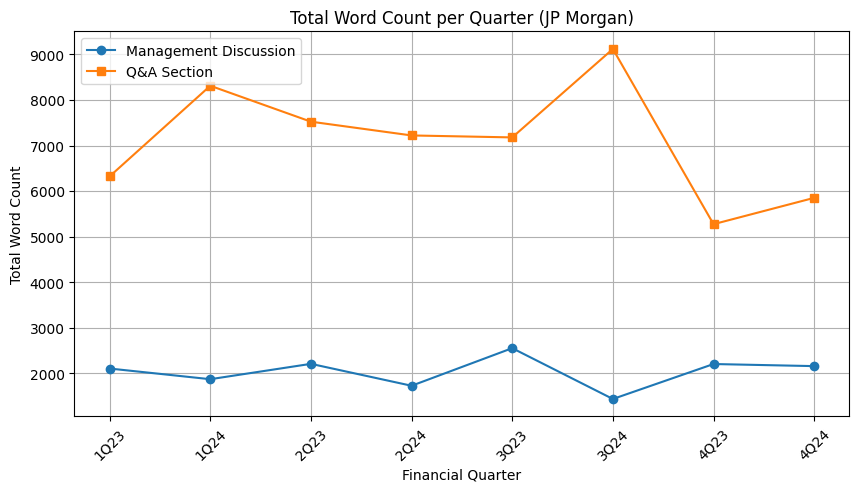

In [ ]:
# Get word count per quarter

management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_discussion_preprocessed .csv")
qa_df = pd.read_csv(f"{BOE_path}/jpmorgan_qa_section_preprocessed.csv")

def compute_word_count(df, text_column, date_column):
    df['word_count'] = df[text_column].astype(str).apply(lambda x: len(x.split()))
    return df.groupby(date_column)['word_count'].sum().reset_index()

management_word_count = compute_word_count(management_df, 'chunk_text', 'financial_quarter')
qa_word_count = compute_word_count(qa_df, 'utterance', 'financial_quarter')

plt.figure(figsize=(10, 5))
plt.plot(management_word_count['financial_quarter'], management_word_count['word_count'], marker='o', label='Management Discussion')
plt.plot(qa_word_count['financial_quarter'], qa_word_count['word_count'], marker='s', label='Q&A Section')

plt.xlabel("Financial Quarter")
plt.ylabel("Total Word Count")
plt.title("Total Word Count per Quarter (JP Morgan)")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()


Observation
- **Q&A Sections Are Significantly Longer** - Q&A word count consistently exceeds 6,000-9,000 words per quarter, while Management Discussion remains relatively stable (~1,500-3,000 words)
- **Q&A Section Shows More Volatility** - Noticeable Q&A peaks in 1Q24 and 3Q24 (8,000-9,000 words) followed by a sharp drop in 4Q23 (5,000 words)
- The small Management dip in 3Q24 followed by a slight rebound suggests a possible seasonal effect or reporting structure shift.

Action: Could consider separating trends by speaker roles in Q&A to understand if certain executives driving longer discussions, or if analysts are becoming more vocal. Could also compare with external events to see if the earnings were surprises or if there were market movements that cause longer Q&As.

**(I checked for macroeconomic events around the 3Q23 dip and there was economic stagnation in the UK (zero growth)  with elevated corporate borrowing rates, this could have driven shorter discussions due to limited new developments, and focus on cost management and cautious outlooks. Conversely, around the 3Q24 spike, there was global economic growth (2.52% growth) and monetary policy adjustments (reducing rates) which may have led to longer discussions)**

# 3. Get word frequency & token distribution (tokenised data)

- Identify most frequently used words in both sections.
- Compare terminology differences between executives (Management Discussion) and analysts (Q&A).
- Assess preprocessing effectiveness (e.g., unwanted tokens, stopword removal).
- Visualize insights using bar charts and word clouds.

I will analyze the tokenized_data column, which contains the preprocessed text.


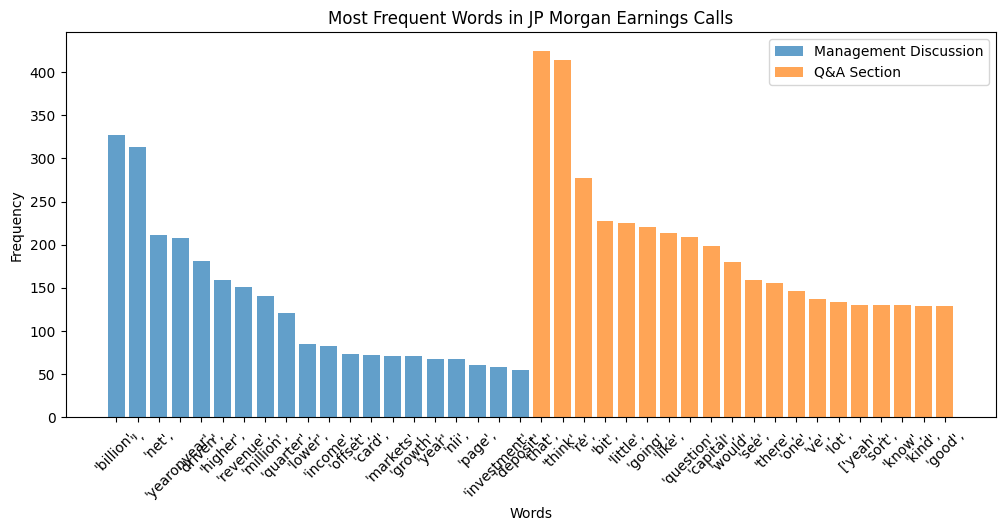

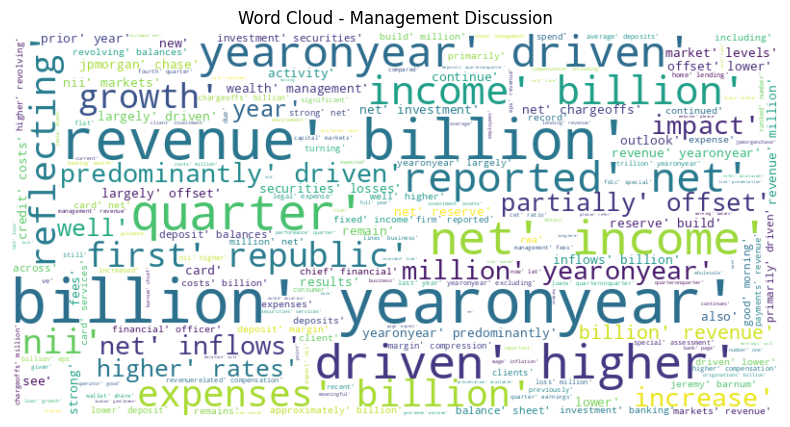

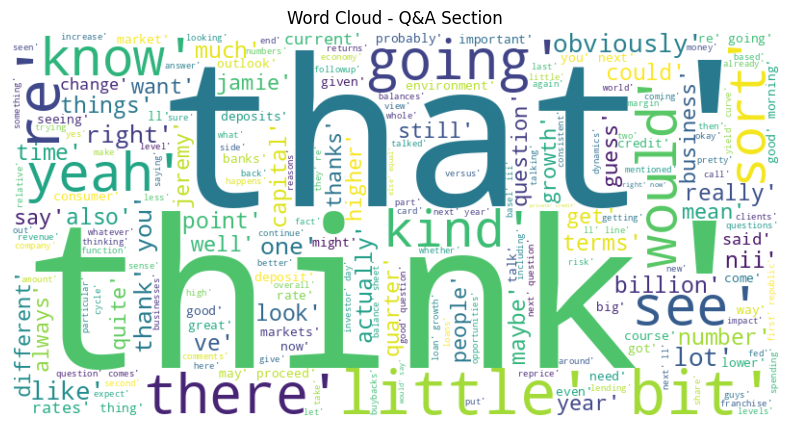

In [ ]:
# Word frequency with word cloud

management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_discussion_preprocessed .csv")
qa_df = pd.read_csv(f"{BOE_path}/jpmorgan_qa_section_preprocessed.csv")

# had to add this as the columns are named slightly differently
text_column_mgmt = 'tokenized_data'
text_column_qa = 'tokenised_data'

def get_most_common_words(df, text_column, top_n=20):
    all_words = ' '.join(df[text_column].dropna()).split()
    word_freq = Counter(all_words)
    return word_freq.most_common(top_n)

top_words_management = get_most_common_words(management_df, text_column_mgmt)
top_words_qa = get_most_common_words(qa_df, text_column_qa)

df_management_words = pd.DataFrame(top_words_management, columns=['Word', 'Frequency'])
df_qa_words = pd.DataFrame(top_words_qa, columns=['Word', 'Frequency'])

# plot most common words
plt.figure(figsize=(12, 5))
plt.bar(df_management_words['Word'], df_management_words['Frequency'], alpha=0.7, label='Management Discussion')
plt.bar(df_qa_words['Word'], df_qa_words['Frequency'], alpha=0.7, label='Q&A Section')
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Frequent Words in JP Morgan Earnings Calls")
plt.legend()
plt.show()

# plot word cloud for management discussion
wordcloud_mgmt = WordCloud(width=800, height=400, background_color='white').generate(' '.join(management_df[text_column_mgmt].dropna()))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_mgmt, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Management Discussion")
plt.show()

# plot word cloud for Q&A section
wordcloud_qa = WordCloud(width=800, height=400, background_color='white').generate(' '.join(qa_df[text_column_qa].dropna()))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_qa, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Q&A Section")
plt.show()

- Management Discussion is dominated by financial terms (e.g., billion, revenue, income, year-on-year)
- Q&A, due to a more conversational style, contains excessive filler words ("kind of", "little bit", "sort of"), indicating a need for improved stopword filtering to refine key insights.

**Action: Enhance stopword removal in Q&A to eliminate conversational clutter.**

# 4. Q&A Analysis (speaker patterns & filtering impact)